## Starter Notebook For The Côte d’Ivoire Byte-Sized Agriculture Challenge

This starter notebook achieves the following:


1.   Load & display satellite images
2.   Build a basic machine learning model
3.   Prepare the predictions for submission.

The machine learning model shown here is by no mean ideal. Winning models should leverage multi-temporal data and not single-date imagery.



# Processing  the GTIFF files


Here's a complete list of **Sentinel-2 bands** along with their **descriptions**, **wavelengths**, and **spatial resolutions**:

---

### 🛰️ **Sentinel-2 Band Overview**

| Band | Name                    | Wavelength (nm) | Resolution (m) | Description |
|------|-------------------------|-----------------|----------------|-------------|
| B1   | Coastal aerosol         | 443             | 60             | Useful for atmospheric correction and aerosol detection. |
| B2   | Blue                    | 490             | 10             | Penetrates water; used for vegetation, water bodies, and coastal mapping. |
| B3   | Green                   | 560             | 10             | Good for assessing plant health and measuring biomass. |
| B4   | Red                     | 665             | 10             | Key band for vegetation discrimination and chlorophyll absorption. |
| B5   | Red Edge 1              | 705             | 20             | Useful for detecting subtle changes in vegetation. |
| B6   | Red Edge 2              | 740             | 20             | Further detail on vegetation, especially stress and growth stages. |
| B7   | Red Edge 3              | 783             | 20             | Extended vegetation monitoring. |
| B8   | NIR (Near Infrared)     | 842             | 10             | Excellent for vegetation vigor, biomass, and land-water contrast. |
| B8A  | Narrow NIR (Red Edge 4) | 865             | 20             | Sensitive to chlorophyll content and canopy structure. |
| B9   | Water Vapor             | 945             | 60             | Atmospheric correction (water vapor absorption). |
| B10  | SWIR – Cirrus           | 1375            | 60             | Detects high-altitude clouds (cirrus); not used for land analysis. |
| B11  | SWIR 1                  | 1610            | 20             | Differentiates clouds, snow, and vegetation moisture. |
| B12  | SWIR 2                  | 2190            | 20             | Useful for geology, soil, and burnt area mapping. |

---

### ✅ Band Groupings by Application

#### **RGB (Natural Color)**
- **B4 (Red)**
- **B3 (Green)**
- **B2 (Blue)**

#### **Vegetation Indices**
- **NDVI:** B8 (NIR) & B4 (Red)
- **EVI:** B8 (NIR), B4 (Red), B2 (Blue)
- **SAVI:** B8 (NIR) & B4 (Red)
- **NDRE:** B8A (Narrow NIR) & B5 (Red Edge)

#### **Cloud/Atmosphere Analysis**
- B1, B9, B10

#### **Snow/Ice Monitoring**
- B3, B11, B12

---


In [1]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install rasterio -q

In [1]:
import os
from pathlib import Path
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import gc

## Data Paths

I want to emphasize the entries shown in generated `train` dataframe for this starter notebook is only January 2024. You model should rely on features extracted over full-year and not just a single month.

In [6]:
DATA_PATH = Path("/content/drive/MyDrive/all_images_s2")
TRAIN_CSV_PATH = "train.csv"
TEST_CSV_PATH = "test.csv"
TRAIN_GEOJSON_PATH = "train.geojson"
TEST_GEOJSON_PATH = "test.geojson"

In [7]:
## Utility function - count the number of files in a folder:

def count_all_files(folder_path):
    file_count = 0
    for root, dirs, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

folder_path = DATA_PATH
total_files = count_all_files(folder_path)

print(f"📁 Total number of images from GEE in '{folder_path}': {total_files}")

📁 Total number of images from GEE in '/content/drive/MyDrive/all_images_s2': 4500


In [8]:
## Load GeoJSon data

def load_geojson(file_path):
  gdf = gpd.read_file(file_path)

  # Convert all dataframe columns to string (to avoid JSON serialization error)
  for col in gdf.select_dtypes(include=['datetime']).columns:
    gdf[col] = gdf[col].astype(str)

  return gdf

In [9]:
## Display basic information about the GeoJSON

def basic_geojson_info(gdf):
  print(f"The columns in the GeoJSON are:\n{gdf.columns}\n")
  print(f"CRS (Coordinate Reference System) of the GeoJSON is: {gdf.crs}\n")
  print(f"Shape of the GeoJSON is: {gdf.shape}\n")
  print(f"The Geometry Type is:{gdf.geom_type.unique()}")

In [10]:
## Load Geojson data
train_gdf = load_geojson(TRAIN_GEOJSON_PATH)
test_gdf = load_geojson(TEST_GEOJSON_PATH)

In [11]:
## Display basic info
basic_geojson_info(train_gdf)
basic_geojson_info(test_gdf)

The columns in the GeoJSON are:
Index(['ID', 'year', 'crop', 'class', 'geometry'], dtype='object')

CRS (Coordinate Reference System) of the GeoJSON is: EPSG:4326

Shape of the GeoJSON is: (953, 5)

The Geometry Type is:['Polygon' 'MultiPolygon']
The columns in the GeoJSON are:
Index(['ID', 'year', 'geometry'], dtype='object')

CRS (Coordinate Reference System) of the GeoJSON is: EPSG:4326

Shape of the GeoJSON is: (282, 3)

The Geometry Type is:['Polygon' 'MultiPolygon']


In [13]:
train_gdf.head()

ID  year    crop  class  \
0  ID_Mrbi2k  2024  Rubber      3   
1  ID_ORmFYt  2024  Rubber      3   
2  ID_2j2bjN  2024  Rubber      3   
3  ID_GsdWS5  2024  Rubber      3   
4  ID_zEYtR5  2024  Rubber      3   

                                            geometry  
0  POLYGON ((-7.47662 4.79479, -7.47672 4.7947, -...  
1  MULTIPOLYGON (((-7.11499 4.76768, -7.11471 4.7...  
2  MULTIPOLYGON (((-7.09768 4.90044, -7.09732 4.9...  
3  MULTIPOLYGON (((-7.11829 4.76918, -7.11714 4.7...  
4  POLYGON ((-7.51713 4.66244, -7.51711 4.66249, ...

In [14]:
test_gdf.head()

ID  year                                           geometry
0  ID_UrUGR0  2024  POLYGON ((-7.56113 4.68498, -7.56119 4.68497, ...
1  ID_3ZmbBi  2024  POLYGON ((-7.53978 4.68285, -7.53978 4.68298, ...
2  ID_tPmH4c  2024  MULTIPOLYGON (((-7.22294 4.69077, -7.22282 4.6...
3  ID_rUfFQH  2024  MULTIPOLYGON (((-7.22599 4.58477, -7.22582 4.5...
4  ID_RrthDZ  2024  MULTIPOLYGON (((-7.09795 4.76096, -7.09771 4.7...

In [15]:
## Load the train/test csv files
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)

In [16]:
train_df.head()

ID  year    crop  class  \
0  ID_Mrbi2k  2024  Rubber      3   
1  ID_ORmFYt  2024  Rubber      3   
2  ID_2j2bjN  2024  Rubber      3   
3  ID_GsdWS5  2024  Rubber      3   
4  ID_zEYtR5  2024  Rubber      3   

                                            geometry  
0  POLYGON ((-7.476615050142024 4.79478762436074,...  
1  MULTIPOLYGON (((-7.1149886710959 4.76768337221...  
2  MULTIPOLYGON (((-7.097675707799493 4.900437859...  
3  MULTIPOLYGON (((-7.118287943114305 4.769177574...  
4  POLYGON ((-7.517130980854245 4.662443210274136...

In [17]:
test_df.head()

ID  year                                           geometry
0  ID_UrUGR0  2024  POLYGON ((-7.561133333333333 4.684975, -7.5611...
1  ID_3ZmbBi  2024  POLYGON ((-7.539784666488248 4.682848657858584...
2  ID_tPmH4c  2024  MULTIPOLYGON (((-7.222944007990868 4.690774365...
3  ID_rUfFQH  2024  MULTIPOLYGON (((-7.225990239817133 4.584773837...
4  ID_RrthDZ  2024  MULTIPOLYGON (((-7.097945340553053 4.760964653...

In [41]:
def find_matching_tiffs(df, data_path):
    """
    Find and collect TIFF file paths from a directory that match IDs in a GeoDataFrame.

    Parameters:
    - df (DataFrame): A DataFrame containing an 'ID' column.
    - data_path (Path or str): Directory path containing TIFF files.

    Returns:
    - List[Path]: List of matching TIFF file paths.
    """
    data_path = Path(data_path)
    matching_tiffs = []

    for idx, row in df.iterrows():
        field_id = row['ID']
        for tif_file in os.listdir(data_path):
            if field_id in tif_file:
                tif_path = data_path / tif_file
                matching_tiffs.append(tif_path)

    return matching_tiffs


In [42]:
# Get the paths of train/test images
train_tiffs = find_matching_tiffs(train_gdf, DATA_PATH)
test_tiffs = find_matching_tiffs(test_gdf, DATA_PATH)

In [43]:
train_tiffs[:5]

[PosixPath('/content/drive/MyDrive/all_images_s2/s2_Rubber_ID_Mrbi2k_2024_02.tif'),
 PosixPath('/content/drive/MyDrive/all_images_s2/s2_Rubber_ID_Mrbi2k_2024_12.tif'),
 PosixPath('/content/drive/MyDrive/all_images_s2/s2_Rubber_ID_Mrbi2k_2024_01.tif'),
 PosixPath('/content/drive/MyDrive/all_images_s2/s2_Rubber_ID_ORmFYt_2024_02.tif'),
 PosixPath('/content/drive/MyDrive/all_images_s2/s2_Rubber_ID_ORmFYt_2024_12.tif')]

In [44]:
test_tiffs[:5]

[PosixPath('/content/drive/MyDrive/all_images_s2/s2_Unknown_ID_UrUGR0_2024_02.tif'),
 PosixPath('/content/drive/MyDrive/all_images_s2/s2_Unknown_ID_UrUGR0_2024_12.tif'),
 PosixPath('/content/drive/MyDrive/all_images_s2/s2_Unknown_ID_UrUGR0_2024_01.tif'),
 PosixPath('/content/drive/MyDrive/all_images_s2/s2_Unknown_ID_3ZmbBi_2024_02.tif'),
 PosixPath('/content/drive/MyDrive/all_images_s2/s2_Unknown_ID_3ZmbBi_2024_12.tif')]

In [45]:
tiffs = [t for t in test_tiffs if 'Unknown' in t.name]

In [46]:
len(tiffs) == len(test_tiffs)

True

## Utility functions Processing & Display S2 images

In [47]:
## Check the size of each of these tifs

def print_tif_sizes(tif_files):
    """
    Prints the size of each TIFF file in MB and GB.

    Parameters:
        tif_files (list): List of TIFF file names (str).
    """
    for file_path in tif_files:

        # Get the size in bytes
        tif_size_bytes = os.path.getsize(file_path)

        # Convert bytes to MB and GB
        tif_size_kb = tif_size_bytes / 1024
        tif_size_mb = tif_size_bytes / (1024 * 1024)
        tif_size_gb = tif_size_bytes / (1024 * 1024 * 1024)

        # Print sizes
        print(f"{file_path.name} size: {tif_size_kb:.2f} KB")
        #print(f"{file_path.name} size: {tif_size_mb:.2f} MB")
        #print(f"{file_path.name} size: {tif_size_gb:.2f} GB")


In [48]:
## Check size of train files
print_tif_sizes(train_tiffs[:10])

s2_Rubber_ID_Mrbi2k_2024_02.tif size: 9.07 KB
s2_Rubber_ID_Mrbi2k_2024_12.tif size: 9.72 KB
s2_Rubber_ID_Mrbi2k_2024_01.tif size: 9.32 KB
s2_Rubber_ID_ORmFYt_2024_02.tif size: 5.61 KB
s2_Rubber_ID_ORmFYt_2024_12.tif size: 5.69 KB
s2_Rubber_ID_ORmFYt_2024_01.tif size: 5.63 KB
s2_Rubber_ID_2j2bjN_2024_02.tif size: 5.57 KB
s2_Rubber_ID_2j2bjN_2024_01.tif size: 5.59 KB
s2_Rubber_ID_GsdWS5_2024_02.tif size: 8.43 KB
s2_Rubber_ID_GsdWS5_2024_12.tif size: 8.81 KB


In [49]:
## Check size of test files
print_tif_sizes(test_tiffs[:10])

s2_Unknown_ID_UrUGR0_2024_02.tif size: 8.75 KB
s2_Unknown_ID_UrUGR0_2024_12.tif size: 9.07 KB
s2_Unknown_ID_UrUGR0_2024_01.tif size: 10.24 KB
s2_Unknown_ID_3ZmbBi_2024_02.tif size: 9.29 KB
s2_Unknown_ID_3ZmbBi_2024_12.tif size: 8.90 KB
s2_Unknown_ID_3ZmbBi_2024_01.tif size: 9.15 KB
s2_Unknown_ID_tPmH4c_2024_02.tif size: 5.03 KB
s2_Unknown_ID_tPmH4c_2024_12.tif size: 5.04 KB
s2_Unknown_ID_tPmH4c_2024_01.tif size: 5.05 KB
s2_Unknown_ID_rUfFQH_2024_02.tif size: 8.54 KB


In [50]:
import rasterio

def get_tif_metadata(tif_path):
    """
    Retrieves and prints metadata for a given TIFF file.

    Parameters:
    - tif_path (str or Path): Path to the TIFF file.

    This function opens the TIFF file, retrieves its dimensions (width, height),
    and the number of bands, then prints the relevant metadata.
    """
    with rasterio.open(tif_path) as src:
        # Get the image width (number of columns)
        width = src.width

        # Get the image height (number of rows)
        height = src.height

        # Get the number of bands in the image (e.g., RGB bands or multispectral bands)
        count = src.count

        # Print image dimensions (width x height) and the number of bands
        print(f"Image Name: {tif_path.name}")
        print(f"Image Dimensions: {width}x{height} pixels")
        print(f"Number of Bands: {count}\n")


## Get Meta Data Information

In [51]:
## Get meta data information for each train tiff
for train_tif in train_tiffs[:10]:
  get_tif_metadata(train_tif)

Image Name: s2_Rubber_ID_Mrbi2k_2024_02.tif
Image Dimensions: 20x15 pixels
Number of Bands: 6

Image Name: s2_Rubber_ID_Mrbi2k_2024_12.tif
Image Dimensions: 20x15 pixels
Number of Bands: 6

Image Name: s2_Rubber_ID_Mrbi2k_2024_01.tif
Image Dimensions: 20x15 pixels
Number of Bands: 6

Image Name: s2_Rubber_ID_ORmFYt_2024_02.tif
Image Dimensions: 8x8 pixels
Number of Bands: 6

Image Name: s2_Rubber_ID_ORmFYt_2024_12.tif
Image Dimensions: 8x8 pixels
Number of Bands: 6

Image Name: s2_Rubber_ID_ORmFYt_2024_01.tif
Image Dimensions: 8x8 pixels
Number of Bands: 6

Image Name: s2_Rubber_ID_2j2bjN_2024_02.tif
Image Dimensions: 6x10 pixels
Number of Bands: 6

Image Name: s2_Rubber_ID_2j2bjN_2024_01.tif
Image Dimensions: 6x10 pixels
Number of Bands: 6

Image Name: s2_Rubber_ID_GsdWS5_2024_02.tif
Image Dimensions: 14x17 pixels
Number of Bands: 6

Image Name: s2_Rubber_ID_GsdWS5_2024_12.tif
Image Dimensions: 14x17 pixels
Number of Bands: 6



In [52]:
## Get meta data for test tiffs
for test_tif in test_tiffs[:10]:
  get_tif_metadata(test_tif)

Image Name: s2_Unknown_ID_UrUGR0_2024_02.tif
Image Dimensions: 19x14 pixels
Number of Bands: 6

Image Name: s2_Unknown_ID_UrUGR0_2024_12.tif
Image Dimensions: 19x14 pixels
Number of Bands: 6

Image Name: s2_Unknown_ID_UrUGR0_2024_01.tif
Image Dimensions: 19x14 pixels
Number of Bands: 6

Image Name: s2_Unknown_ID_3ZmbBi_2024_02.tif
Image Dimensions: 19x13 pixels
Number of Bands: 6

Image Name: s2_Unknown_ID_3ZmbBi_2024_12.tif
Image Dimensions: 19x13 pixels
Number of Bands: 6

Image Name: s2_Unknown_ID_3ZmbBi_2024_01.tif
Image Dimensions: 19x13 pixels
Number of Bands: 6

Image Name: s2_Unknown_ID_tPmH4c_2024_02.tif
Image Dimensions: 5x5 pixels
Number of Bands: 6

Image Name: s2_Unknown_ID_tPmH4c_2024_12.tif
Image Dimensions: 5x5 pixels
Number of Bands: 6

Image Name: s2_Unknown_ID_tPmH4c_2024_01.tif
Image Dimensions: 5x5 pixels
Number of Bands: 6

Image Name: s2_Unknown_ID_rUfFQH_2024_02.tif
Image Dimensions: 11x21 pixels
Number of Bands: 6



## Get min & max size from raster images

In [53]:
## Utility function for getting the images with min/max size

def get_max_tile_size(tif_paths):
    """
    Calculate the maximum tile size (height × width) from a list of tif file paths.

    Parameters:
    - tif_paths (list of str or Path): List of paths to .tif files

    Returns:
    - max_size (int): Maximum number of pixels in a tile
    - shape (tuple): Shape (height, width) of the largest tile
    - file (str): Path of the tif file with the largest tile
    """
    max_size = 0
    max_shape = (0, 0)
    max_file = None
    max_idx = None

    for idx, path in enumerate(tif_paths):
        with rasterio.open(path) as src:
            height, width = src.height, src.width
            size = height * width
            if size > max_size:
                max_size = size
                max_shape = (height, width)
                max_file = path
                max_idx = idx

    return max_size, max_shape, str(max_file), max_idx



In [54]:
def get_min_tile_size(tif_paths):
    """
    Calculate the minimum tile size (height × width) from a list of tif file paths.

    Parameters:
    - tif_paths (list of str or Path): List of paths to .tif files

    Returns:
    - min_size (int): Minimum number of pixels in a tile
    - shape (tuple): Shape (height, width) of the smallest tile
    - file (str): Path of the tif file with the smallest tile
    """
    min_size = float('inf')
    min_shape = (0, 0)
    min_file = None
    min_idx = None

    for idx, path in enumerate(tif_paths):
        with rasterio.open(path) as src:
            height, width = src.height, src.width
            size = height * width
            if size < min_size:
                min_size = size
                min_shape = (height, width)
                min_file = path
                min_idx = idx

    return min_size, min_shape, str(min_file), min_idx


In [55]:
# Get max tile size of train
max_train_tif_size, max_train_tif_shape, max_train_tif_file, max_train_idx = get_max_tile_size(train_tiffs)
min_train_tif_size, min_train_tif_shape, min_train_tif_file, min_train_idx = get_min_tile_size(train_tiffs)

# Get max tile size of test
max_test_tif_size, max_test_tif_shape, max_test_tif_file, max_test_idx = get_max_tile_size(test_tiffs)
min_test_tif_size, min_test_tif_shape, min_test_tif_file, min_test_idx = get_min_tile_size(test_tiffs)

# Overall max_tile_size
max_tile_height = max(max_train_tif_shape[0], max_test_tif_shape[0])
max_tile_width = max(max_train_tif_shape[1], max_test_tif_shape[1])

# Assume a square tile
MAX_TILE_SIZE = max(max_tile_height, max_tile_width)

In [56]:
print(f"The maximum tile size for train is at {max_train_idx} with: (height x width) = {max_train_tif_shape}.")
print(f"The raster image from train with maximum dimension is:\n\t{max_train_tif_file}.\n")
print(f"The minimum tile size for train is at {min_train_idx}: (height x width) = {min_train_tif_shape}.")
print(f"The raster image from train with the minimum dimension is:\n\t{min_train_tif_file}.\n")

print(f"The maximum tile size for test is at {max_test_idx} with : (height x width) = {max_test_tif_shape}.")
print(f"The raster image from test with maximum dimension is:\n\t{max_test_tif_file}.\n")
print(f"The minimum tile size for test is at {min_test_idx}: (height x width) = {min_test_tif_shape}.")
print(f"The raster image from test with the minimum dimension is:\n\t{min_test_tif_file}.")

print(f"\nThe maximum tile size to use: MAX_TILE_SIZE = {(MAX_TILE_SIZE, MAX_TILE_SIZE)}.")

The maximum tile size for train is at 1602 with: (height x width) = (236, 237).
The raster image from train with maximum dimension is:
	/content/drive/MyDrive/all_images_s2/s2_Cocoa_ID_xXViIp_2024_02.tif.

The minimum tile size for train is at 1994: (height x width) = (1, 2).
The raster image from train with the minimum dimension is:
	/content/drive/MyDrive/all_images_s2/s2_Cocoa_ID_RPqPKr_2024_02.tif.

The maximum tile size for test is at 577 with : (height x width) = (245, 326).
The raster image from test with maximum dimension is:
	/content/drive/MyDrive/all_images_s2/s2_Unknown_ID_r3FyhM_2024_02.tif.

The minimum tile size for test is at 916: (height x width) = (2, 4).
The raster image from test with the minimum dimension is:
	/content/drive/MyDrive/all_images_s2/s2_Unknown_ID_eXHj4o_2024_02.tif.

The maximum tile size to use: MAX_TILE_SIZE = (326, 326).


## Visualisation Functions

In [57]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.windows import Window

## These functions assumes that the 6 bands downloaded are [B2, B3, B4, B8, B11, B12]

def process_window(tif_path, window=None):
    """
    Reads a window or full data from a GeoTIFF and handles NoData values.
    """
    with rasterio.open(tif_path) as src:
        if window is not None:
            data = src.read(window=window)
        else:
            data = src.read()

        nodata_value = src.nodata
        if nodata_value is not None:
            data = np.ma.masked_equal(data, nodata_value)

    return data

def normalize_band(band):
    """
    Normalizes a band to the [0, 1] range, safely handling NaN/masked values.
    """
    band = np.ma.masked_invalid(band)
    band_min = band.min()
    band_max = band.max()

    if band_max > band_min:
        return (band - band_min) / (band_max - band_min)
    else:
        return band  # Return unchanged if no variation

def plot_rgb_window(tif_path, window=None, r_band_idx=2, g_band_idx=1, b_band_idx=0):
    """
    Plots an RGB composite image from the specified bands.
    """
    data = process_window(tif_path, window)

    red = normalize_band(data[r_band_idx, :, :])
    green = normalize_band(data[g_band_idx, :, :])
    blue = normalize_band(data[b_band_idx, :, :])

    rgb = np.stack([red, green, blue], axis=-1)

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb)
    plt.title(f"RGB Composite")
    plt.axis("off")
    plt.show()

def plot_single_band(tif_path, window=None, band_idx=0, cmap='gray'):
    """
    Plots a single band from the GeoTIFF.
    """
    data = process_window(tif_path, window)
    band_normalized = normalize_band(data[band_idx, :, :])

    plt.figure(figsize=(8, 8))
    plt.imshow(band_normalized, cmap=cmap)
    plt.title(f"Band {band_idx}")
    plt.axis("off")
    plt.show()

def plot_vegetation_index(tif_path, window=None, red_band_idx=2, nir_band_idx=3, cmap='RdYlGn'):
    """
    Plots NDVI using the given Red and NIR band indices.
    """
    data = process_window(tif_path, window)
    red = data[red_band_idx, :, :]
    nir = data[nir_band_idx, :, :]
    ndvi = (nir - red) / (nir + red)

    plt.figure(figsize=(8, 8))
    plt.imshow(ndvi, cmap=cmap)
    plt.title(f"Vegetation Index (NDVI)")
    plt.axis("off")
    plt.show()

def plot_evi(tif_path, window, red_band_idx=2, blue_band_idx=0, nir_band_idx=3, cmap='Spectral'):
    """
    Plots EVI using Red, Blue, and NIR band indices.
    Alternative cmaps 'coolwarm', 'PiYG', 'viridis'
    """
    data = process_window(tif_path, window)
    red = data[red_band_idx, :, :]
    blue = data[blue_band_idx, :, :]
    nir = data[nir_band_idx, :, :]

    L = 10000

    evi = 2.5 * ((nir - red) / (nir + 6*red - 7.5*blue + L))

    plt.figure(figsize=(8, 8))
    plt.imshow(evi, cmap=cmap)
    plt.title(f"Enhanced Vegetation Index (EVI) - Window: {window}")
    plt.axis("off")
    plt.show()


def plot_savi(tif_path, window=None, red_band_idx=2, nir_band_idx=3, L=0.5, cmap='YlGn'):
    """
    Plots SAVI using Red and NIR bands with a soil brightness correction factor.
    """
    data = process_window(tif_path, window)
    red = data[red_band_idx, :, :]
    nir = data[nir_band_idx, :, :]

    savi = ((nir - red) / (nir + red + L)) * (1 + L)

    plt.figure(figsize=(8, 8))
    plt.imshow(savi, cmap=cmap)
    plt.title(f"Soil Adjusted Vegetation Index (SAVI)")
    plt.axis("off")
    plt.show()


## Visualize the Train TIFFS

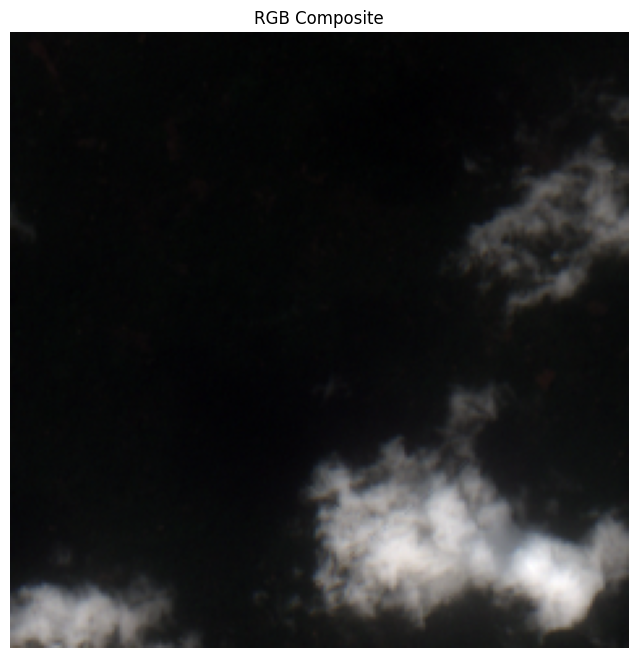

In [58]:
window = None #Window(0, 0, 1024, 1024)
# Plot RGB image (Red: band 2, Green: band 1, Blue: band 0)
plot_rgb_window(train_tiffs[max_train_idx], window, r_band_idx=2, g_band_idx=1, b_band_idx=0)

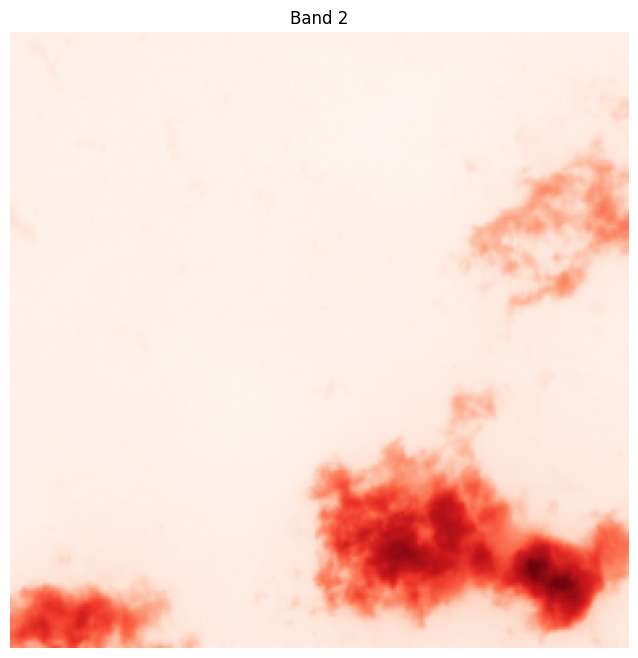

In [59]:
# Plot a single band (e.g., Red band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=2, cmap='Reds')

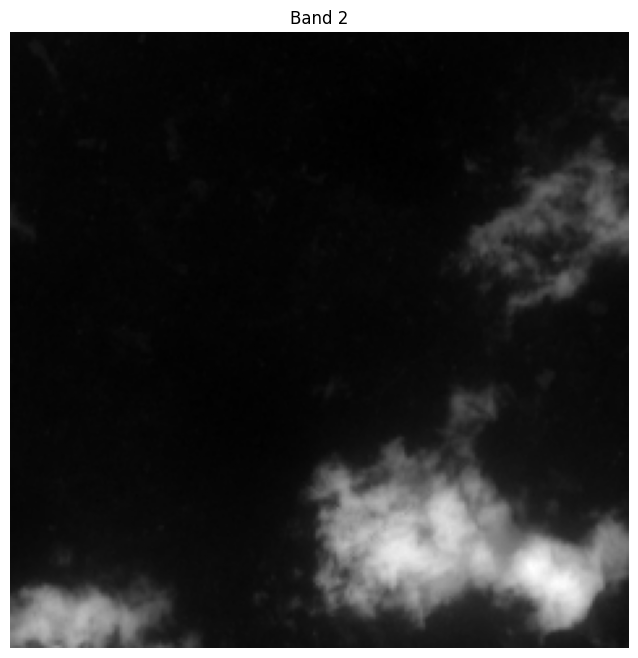

In [60]:
# Plot a single band (e.g., Red band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=2, cmap='gray')

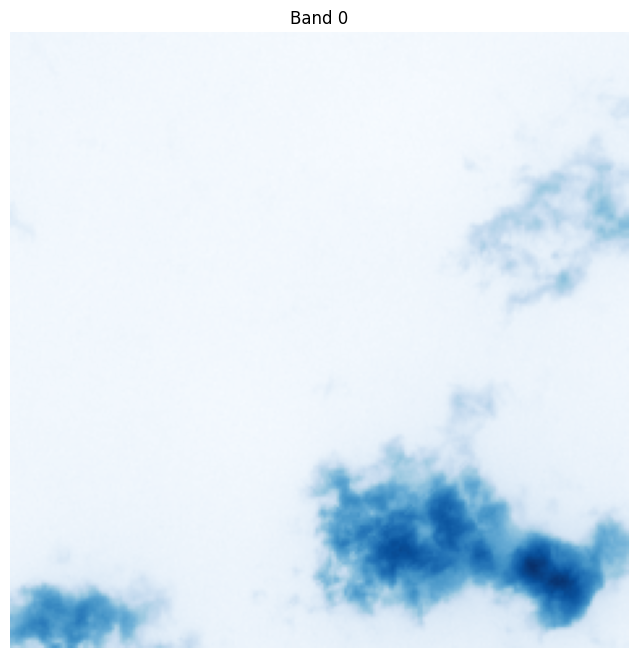

In [61]:
# Plot a single band (e.g., Blue band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=0, cmap='Blues')

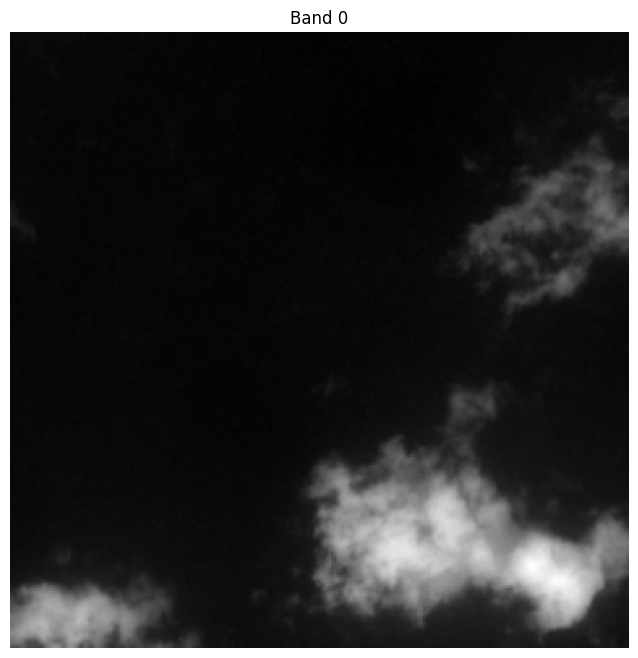

In [62]:
# Plot a single band (e.g., Blue band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=0, cmap='gray')

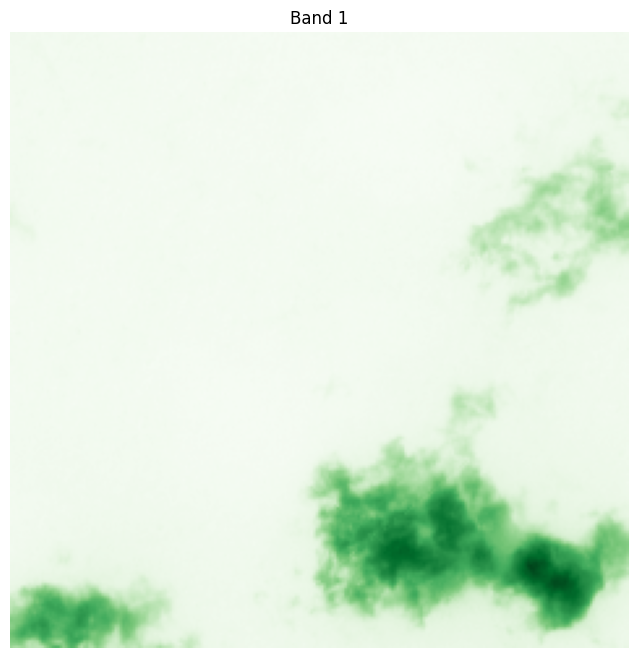

In [63]:
# Plot a single band (e.g., Green band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=1, cmap='Greens')

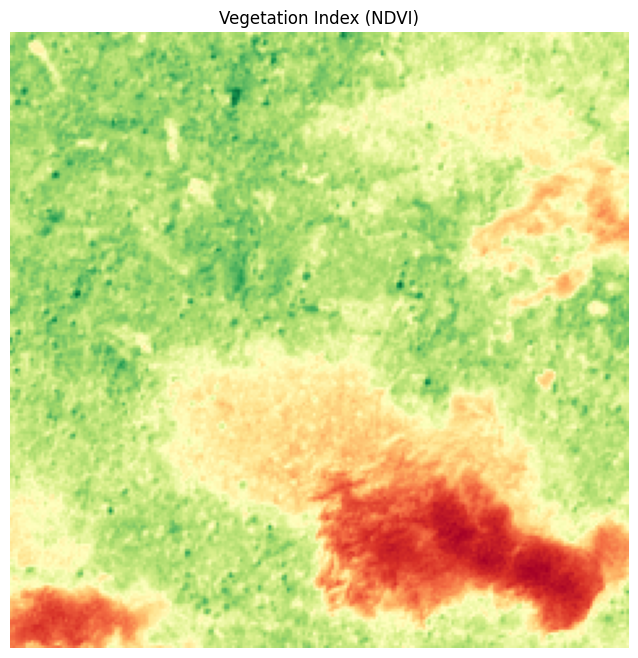

In [64]:
# Plot Vegetation Index (NDVI)
# cmap: 'viridis', 'BrBG', 'YlGn', 'PiYG', 'RdYlGn'
plot_vegetation_index(train_tiffs[max_train_idx], window, red_band_idx=2, nir_band_idx=3, cmap='RdYlGn')

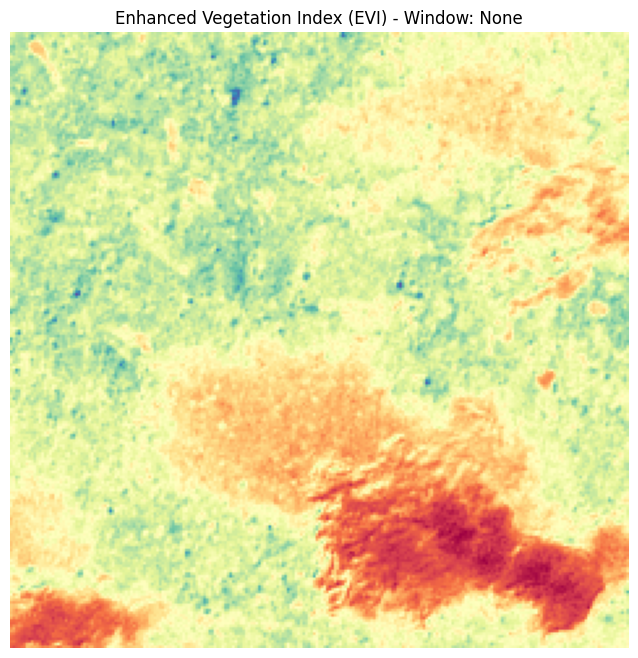

In [65]:
# Plot Enhanced Vegetation Index (EVI)
# cmap: 'coolwarm', 'PiYG', 'viridis', 'Spectral'
plot_evi(train_tiffs[max_train_idx], window, red_band_idx=2, blue_band_idx=0, nir_band_idx=3, cmap='Spectral')

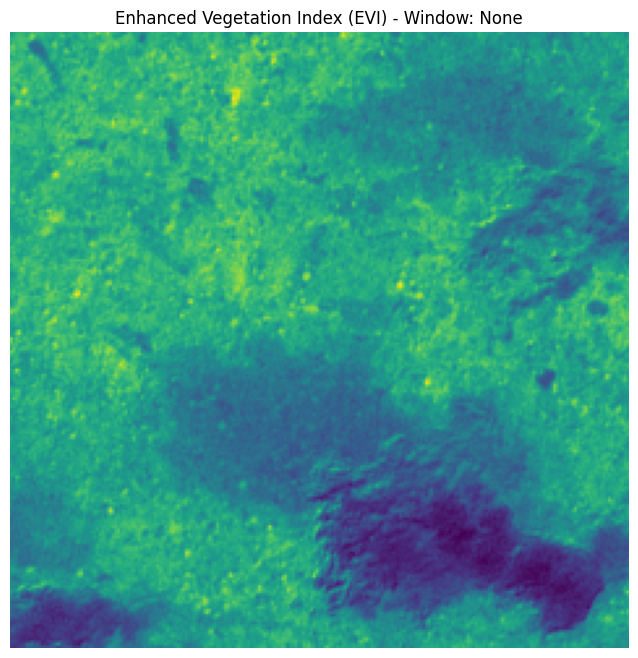

In [66]:
plot_evi(train_tiffs[max_train_idx], window, red_band_idx=2, blue_band_idx=0, nir_band_idx=3, cmap='viridis')

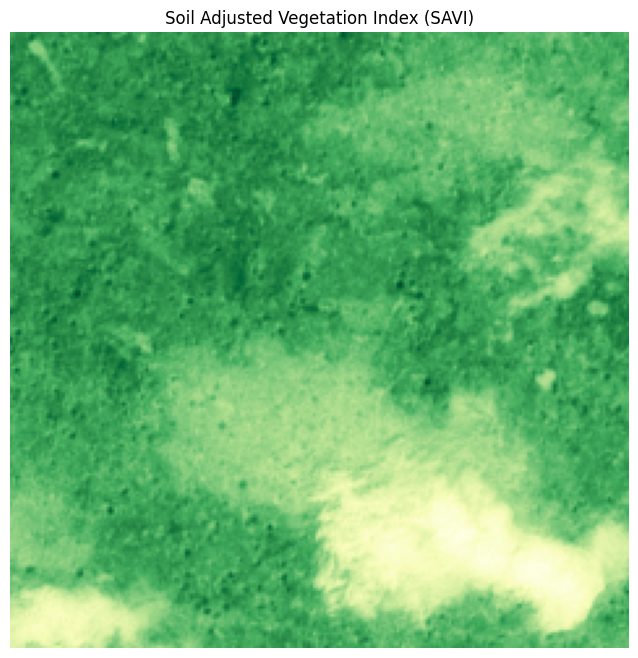

In [67]:
# Plot Soil Adjusted Vegetation Index (SAVI)
# cmap 'Greens', 'YlGnBu', 'YlGn'
plot_savi(train_tiffs[max_train_idx], window, red_band_idx=2, nir_band_idx=3, cmap='YlGn')

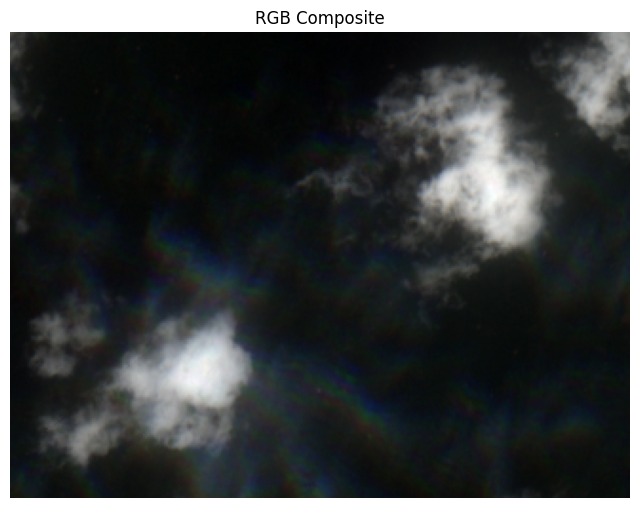

In [68]:
## Plot RGB image (Red: band 3, Green: band 2, Blue: band 1)
plot_rgb_window(test_tiffs[max_test_idx], window, r_band_idx=2, g_band_idx=1, b_band_idx=0)

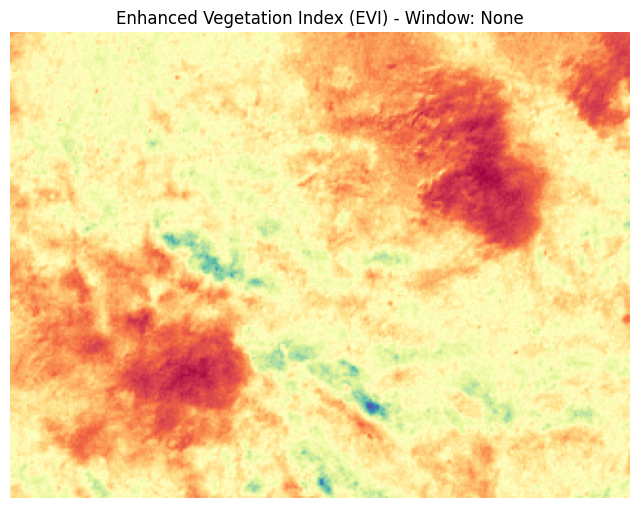

In [69]:
plot_evi(test_tiffs[max_test_idx], window, red_band_idx=2, blue_band_idx=0, nir_band_idx=3, cmap='Spectral')

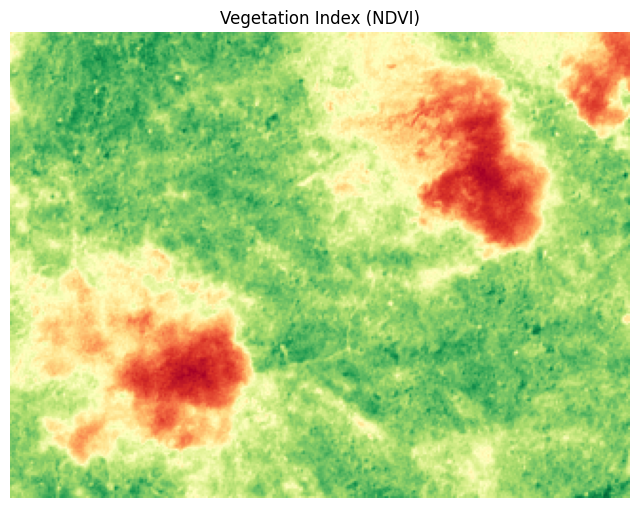

In [70]:
plot_vegetation_index(test_tiffs[max_test_idx], window, red_band_idx=2, nir_band_idx=3, cmap='RdYlGn')

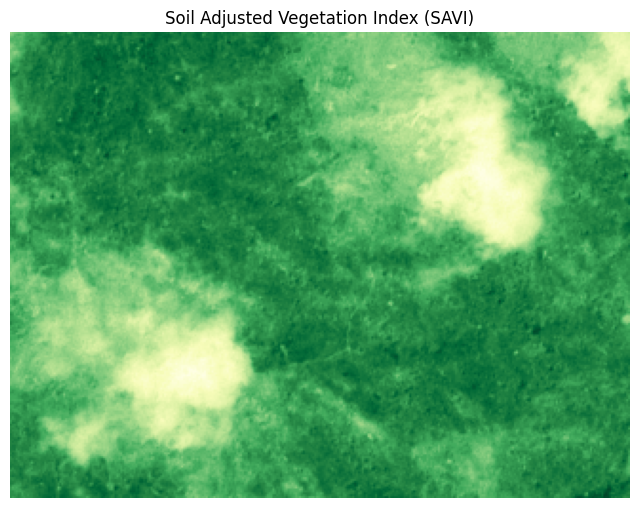

In [71]:
plot_savi(test_tiffs[max_test_idx], window, red_band_idx=2, nir_band_idx=3, cmap='YlGn')

In [72]:
## View the train_gdf_idea
train_gdf.head()

ID  year    crop  class  \
0  ID_Mrbi2k  2024  Rubber      3   
1  ID_ORmFYt  2024  Rubber      3   
2  ID_2j2bjN  2024  Rubber      3   
3  ID_GsdWS5  2024  Rubber      3   
4  ID_zEYtR5  2024  Rubber      3   

                                            geometry  
0  POLYGON ((-7.47662 4.79479, -7.47672 4.7947, -...  
1  MULTIPOLYGON (((-7.11499 4.76768, -7.11471 4.7...  
2  MULTIPOLYGON (((-7.09768 4.90044, -7.09732 4.9...  
3  MULTIPOLYGON (((-7.11829 4.76918, -7.11714 4.7...  
4  POLYGON ((-7.51713 4.66244, -7.51711 4.66249, ...

In [73]:
train_gdf['ID'].values[:10]

array(['ID_Mrbi2k', 'ID_ORmFYt', 'ID_2j2bjN', 'ID_GsdWS5', 'ID_zEYtR5',
       'ID_IODka8', 'ID_le3tqk', 'ID_1tF3p3', 'ID_T8lCHY', 'ID_rxbX82'],
      dtype=object)

In [74]:
train_gdf.columns

Index(['ID', 'year', 'crop', 'class', 'geometry'], dtype='object')

In [75]:
train_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [76]:
import gc
gc.collect()

13084

## Create a DataFrame with the TIF Data

For this toy example, the TIFFs file corresponding to the month of January are used.

In [77]:
## Helper function - returns a tif path if an image was downloaded
## for the given month & year

def get_tiff_path(idx, month_idx, year, tif_paths):
    month_str = f"{month_idx:02d}"  # ensures 01, 02, ..., 12
    identifier = f"{idx}_{year}_{month_str}"

    for tif_path in tif_paths:
        if identifier in tif_path.name:
            return tif_path

    return None  # Only return None if no match found


In [78]:
YEAR = 2024
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

def build_tiff_dataframe(gdf, tif_paths, year=2024, is_train=True, month_limit=12):
    """
    Constructs a DataFrame mapping each ID and month to its corresponding TIFF path.

    Parameters:
    - gdf: GeoDataFrame with 'ID' (and optionally 'crop', 'class' if is_train)
    - tif_paths: list or path collection of TIFF files
    - year: year to use for matching filenames
    - is_train: flag to indicate if it's for training (includes 'crop' and 'class')
    - month_range: limit the data to generating the dataframe for a specific range of months

    Returns:
    - A pandas DataFrame with columns: ID, year, month, tifPath, (optional: crop, class)
    """

    data = []
    for month_idx in range(1, month_limit+1):
        month = MONTHS[month_idx - 1]
        for idx in gdf['ID'].values:
            tif_path = get_tiff_path(idx, month_idx, year, tif_paths)
            entry = {
                "ID": f"{idx}_{month}",
                "year": year,
                "month": month,
                "tifPath": str(tif_path) if tif_path else None,
            }
            if is_train:
                entry["crop"] = gdf.loc[gdf['ID'] == idx, 'crop'].values[0]
                entry["class"] = gdf.loc[gdf['ID'] == idx, 'class'].values[0]
            data.append(entry)

    return pd.DataFrame(data)


def build_tiff_dataframe_single_month(gdf, tif_paths, year=2024, is_train=True, month_idx=1):
    """
    Constructs a DataFrame mapping each ID and month to its corresponding TIFF path.

    Parameters:
    - gdf: GeoDataFrame with 'ID' (and optionally 'crop', 'class' if is_train)
    - tif_paths: list or path collection of TIFF files
    - year: year to use for matching filenames
    - is_train: flag to indicate if it's for training (includes 'crop' and 'class')
    - month_range: limit the data to generating the dataframe for a specific range of months

    Returns:
    - A pandas DataFrame with columns: ID, year, month, tifPath, (optional: crop, class)
    """

    data = []
    month = MONTHS[month_idx - 1]
    for idx in gdf['ID'].values:
      tif_path = get_tiff_path(idx, month_idx, year, tif_paths)
      entry = {
          "ID": f"{idx}_{month}",
          "year": year,
          "month": month,
          "tifPath": str(tif_path) if tif_path else None,
          }
      if is_train:
        entry["crop"] = gdf.loc[gdf['ID'] == idx, 'crop'].values[0]
        entry["class"] = gdf.loc[gdf['ID'] == idx, 'class'].values[0]
      data.append(entry)

    return pd.DataFrame(data)

## Example restricted to a single month for now.



In [79]:
## Build a toy train dataframe for a single month (January)
df_train = build_tiff_dataframe_single_month(train_gdf, train_tiffs, year=YEAR, is_train=True, month_idx=1)

In [81]:
df_train.head(10)

ID  year month  \
0  ID_Mrbi2k_Jan  2024   Jan   
1  ID_ORmFYt_Jan  2024   Jan   
2  ID_2j2bjN_Jan  2024   Jan   
3  ID_GsdWS5_Jan  2024   Jan   
4  ID_zEYtR5_Jan  2024   Jan   
5  ID_IODka8_Jan  2024   Jan   
6  ID_le3tqk_Jan  2024   Jan   
7  ID_1tF3p3_Jan  2024   Jan   
8  ID_T8lCHY_Jan  2024   Jan   
9  ID_rxbX82_Jan  2024   Jan   

                                             tifPath    crop  class  
0  /content/drive/MyDrive/all_images_s2/s2_Rubber...  Rubber      3  
1  /content/drive/MyDrive/all_images_s2/s2_Rubber...  Rubber      3  
2  /content/drive/MyDrive/all_images_s2/s2_Rubber...  Rubber      3  
3  /content/drive/MyDrive/all_images_s2/s2_Rubber...  Rubber      3  
4  /content/drive/MyDrive/all_images_s2/s2_Rubber...  Rubber      3  
5  /content/drive/MyDrive/all_images_s2/s2_Rubber...  Rubber      3  
6  /content/drive/MyDrive/all_images_s2/s2_Palm_I...    Palm      2  
7  /content/drive/MyDrive/all_images_s2/s2_Palm_I...    Palm      2  
8  /content/drive/MyDrive/all_images_s2/s2_Palm_I...    Palm      2  
9  /content/drive/MyDrive/all_images_s2/s2_Rubber...  Rubber      3

In [82]:
df_train.shape

(953, 6)

In [83]:
## Are there any missing entries in January
df_train[df_train['tifPath'].isna()].sum()

ID         0
year       0
month      0
tifPath    0
crop       0
class      0
dtype: object

In [84]:
print(f"The length of train_df restricted to 1 month is: {len(df_train)} as expected {len(train_gdf)}")

The length of train_df restricted to 1 month is: 953 as expected 953


In [85]:
# create an array that map the crop label to the class using the train_gdf
crop_mapping = {int(class_id) : crop_label  for crop_label, class_id in zip(train_gdf['crop'].unique(), train_gdf['class'].unique())}
crop_mapping

{3: 'Rubber', 2: 'Palm', 1: 'Cocoa'}

In [86]:
test_gdf.head()

ID  year                                           geometry
0  ID_UrUGR0  2024  POLYGON ((-7.56113 4.68498, -7.56119 4.68497, ...
1  ID_3ZmbBi  2024  POLYGON ((-7.53978 4.68285, -7.53978 4.68298, ...
2  ID_tPmH4c  2024  MULTIPOLYGON (((-7.22294 4.69077, -7.22282 4.6...
3  ID_rUfFQH  2024  MULTIPOLYGON (((-7.22599 4.58477, -7.22582 4.5...
4  ID_RrthDZ  2024  MULTIPOLYGON (((-7.09795 4.76096, -7.09771 4.7...

In [87]:
test_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [88]:
## Build test_df (Let is_train to True for now because, I am going to encode the class)
df_test = build_tiff_dataframe_single_month(test_gdf, test_tiffs, year=YEAR, is_train=False, month_idx=1)

In [89]:
df_test.head()

ID  year month  \
0  ID_UrUGR0_Jan  2024   Jan   
1  ID_3ZmbBi_Jan  2024   Jan   
2  ID_tPmH4c_Jan  2024   Jan   
3  ID_rUfFQH_Jan  2024   Jan   
4  ID_RrthDZ_Jan  2024   Jan   

                                             tifPath  
0  /content/drive/MyDrive/all_images_s2/s2_Unknow...  
1  /content/drive/MyDrive/all_images_s2/s2_Unknow...  
2  /content/drive/MyDrive/all_images_s2/s2_Unknow...  
3  /content/drive/MyDrive/all_images_s2/s2_Unknow...  
4  /content/drive/MyDrive/all_images_s2/s2_Unknow...

In [92]:
## Are there any missing entries in January
df_test[df_test['tifPath'].isna()].sum()

ID         0
year       0
month      0
tifPath    0
dtype: object

In [90]:
df_test.shape

(282, 4)

### Basic Preprocessing

In [91]:
# Rename class to Target
df_train = df_train.rename(columns={'crop': 'Target'})

df_train.head()

ID  year month  \
0  ID_Mrbi2k_Jan  2024   Jan   
1  ID_ORmFYt_Jan  2024   Jan   
2  ID_2j2bjN_Jan  2024   Jan   
3  ID_GsdWS5_Jan  2024   Jan   
4  ID_zEYtR5_Jan  2024   Jan   

                                             tifPath  Target  class  
0  /content/drive/MyDrive/all_images_s2/s2_Rubber...  Rubber      3  
1  /content/drive/MyDrive/all_images_s2/s2_Rubber...  Rubber      3  
2  /content/drive/MyDrive/all_images_s2/s2_Rubber...  Rubber      3  
3  /content/drive/MyDrive/all_images_s2/s2_Rubber...  Rubber      3  
4  /content/drive/MyDrive/all_images_s2/s2_Rubber...  Rubber      3

## Pipeline for Crop Classification

These functions are used for building a basic machine learning model and displaying the target distribution.

In [94]:
import os
import rasterio
import numpy as np
import pandas as pd
from rasterio.windows import Window
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.metrics import classification_report, accuracy_score

TILE_SIZE = MAX_TILE_SIZE

def extract_ndvi(nir_band, red_band, epsilon=1e-8):
    """ Calculate NDVI from NIR and Red bands """
    return (nir_band - red_band) / (nir_band + red_band + epsilon)

def extract_savi(nir_band, red_band, L=0.5):
    """ Calculate SAVI from NIR and Red bands """
    return ((nir_band - red_band) * (1 + L)) / (nir_band + red_band + L)

def extract_evi(nir_band, red_band, blue_band, G=2.5, C1=6, C2=7.5, L=10000):
    """ Calculate EVI from NIR, Red, and Blue bands """
    return G * ((nir_band - red_band) / (nir_band + C1 * red_band - C2 * blue_band + L))


def process_and_return_tiles(df, is_train=True, tile_size=TILE_SIZE):
    all_tiles = []
    all_labels = []

    for _, row in df.iterrows():
        tile_path = row['tifPath']

        if is_train:
            label_vector = [row['Target']]
        else:
            label_vector = None

        if tile_path and os.path.exists(tile_path):
            try:
                with rasterio.open(tile_path) as src:
                    raster = src.read()  # (bands, height, width)

                # Optional: pad if smaller than tile_size
                bands, height, width = raster.shape
                padded = np.zeros((bands, tile_size, tile_size))
                padded[:, :height, :width] = raster

                all_tiles.append(padded)

                if is_train:
                    all_labels.append(label_vector)  # Append as a single list, not extend

            except Exception as e:
                print(f"⚠️ Failed to process {tile_path}: {e}")
                continue

    all_tiles_array = np.stack(all_tiles)  # shape: (N, C, H, W)
    all_labels_array = np.array(all_labels) if is_train else None  # shape: (N, 3)

    return all_tiles_array, all_labels_array




def extract_features_from_tiles(tiles):
    """Extract statistical features (mean, median, std, min, max) from each band and index in a tile."""
    features = []

    for tile in tiles:
        # Assuming band order: B2 (Blue), B3 (Green), B4 (Red), B8 (NIR), B11, B12
        blue = tile[0]
        green = tile[1]
        red = tile[2]
        nir = tile[3]
        b11 = tile[4]
        b12 = tile[5]

        # Compute indices
        ndvi = extract_ndvi(nir, red)
        savi = extract_savi(nir, red)
        evi = extract_evi(nir, red, blue)

        # Function to get basic stats
        def stats(arr):
            return [
                np.nanmean(arr),
                np.nanmedian(arr),
                np.nanstd(arr),
                np.nanmin(arr),
                np.nanmax(arr)
            ]

        # Feature vector
        feature_vector = (
            stats(blue) + stats(green) + stats(red) +
            stats(nir) + stats(b11) + stats(b12) +
            stats(ndvi) + stats(savi) + stats(evi)
        )

        features.append(feature_vector)

    # Column names
    stat_names = ['mean', 'median', 'std', 'min', 'max']
    bands = ['B2_Blue', 'B3_Green', 'B4_Red', 'B8_NIR', 'B11', 'B12', 'NDVI', 'SAVI', 'EVI']
    columns = [f"{band}_{stat}" for band in bands for stat in stat_names]

    return pd.DataFrame(features, columns=columns)


In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import plotly.express as px
import numpy as np
import pandas as pd

def train_classifier(X_train, y_train):
    """Train Random Forest Classifier."""
    # Convert one-hot to integer labels
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        y_train = np.argmax(y_train, axis=1)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    return clf

def evaluate_classifier_multi(clf, X_test, y_test):
    """Evaluate the classifier."""
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    y_pred = clf.predict(X_test)

    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    # Optional: class-level accuracy
    class_labels = np.unique(y_test)
    for cls in class_labels:
        cls_acc = np.mean(y_pred[y_test == cls] == cls)
        print(f"Accuracy for class {cls}: {cls_acc:.2f}")


def evaluate_classifier(clf, X_test, y_test):
    """Evaluate the classifier on multi-class single-label targets (non-binary encoded)."""

    # Flatten if y_test is nested like [['Cocoa'], ['Palm'], ...]
    y_test = np.ravel(y_test)

    # Predict
    y_pred = clf.predict(X_test)

    # Flatten prediction as well (if needed)
    y_pred = np.ravel(y_pred)

    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    # Class-level accuracy
    class_labels = np.unique(y_test)
    for cls in class_labels:
        cls_acc = np.mean(y_pred[y_test == cls] == cls)
        print(f"Accuracy for class '{cls}': {cls_acc:.2f}")



def plot_class_distribution(y):
    """Plot distribution of crop types from string class names with custom color mapping."""

    # Flatten the nested list/array
    y_flat = np.array(y).flatten()

    # Map crop names to numeric values
    class_map = {'Cocoa': 1, 'Palm': 2, 'Rubber': 3}
    reverse_map = {1: 'Cocoa', 2: 'Palm', 3: 'Rubber'}
    color_map = {'Cocoa': 'brown', 'Palm': 'green', 'Rubber': 'darkgray'}

    # Convert class names to numeric labels
    y_numeric = [class_map.get(label) for label in y_flat if label in class_map]

    # Convert back to names for counting and plotting
    y_named = [reverse_map[label] for label in y_numeric]

    # Create distribution dataframe
    crop_distribution = pd.Series(y_named).value_counts().reset_index()
    crop_distribution.columns = ['Target', 'Count']

    # Plot using Plotly
    fig = px.bar(
        crop_distribution,
        x='Target',
        y='Count',
        title="Crop Distribution",
        color='Target',
        color_discrete_map=color_map
    )

    fig.show()


In [96]:
df_train['tifPath'].shape

(953,)

In [97]:
# MAIN PIPELINE

# 1. Process the raster
tiles_array, labels = process_and_return_tiles(df_train)
print(f"The shape of tiles_array is: {tiles_array.shape}")
print(f"The length of labels is: {len(labels)}")

The shape of tiles_array is: (953, 6, 326, 326)
The length of labels is: 953


In [98]:
# 2. Extract features from tiles (pixel values, NDVI, SAVI, and EVI)
X = extract_features_from_tiles(tiles_array)

y = np.array(labels)

In [99]:
tiles_array[0].shape

(6, 326, 326)

In [100]:
X.shape, y.shape

((953, 45), (953, 1))

In [101]:
X.head()

B2_Blue_mean  B2_Blue_median  B2_Blue_std  B2_Blue_min  B2_Blue_max  \
0      6.401342             0.0   120.315030          0.0       2298.0   
1      1.339950             0.0    54.586795          0.0       2246.0   
2      1.264133             0.0    53.188320          0.0       2263.0   
3      5.082860             0.0   107.290224          0.0       2324.0   
4      2.543368             0.0    75.334734          0.0       2274.0   

   B3_Green_mean  B3_Green_median  B3_Green_std  B3_Green_min  B3_Green_max  \
0       5.923868              0.0    111.343031           0.0        2139.0   
1       1.239226              0.0     50.484065           0.0        2078.0   
2       1.180426              0.0     49.667011           0.0        2125.0   
3       4.760379              0.0    100.486795           0.0        2201.0   
4       2.321785              0.0     68.773800           0.0        2098.0   

   ...  SAVI_mean  SAVI_median  SAVI_std  SAVI_min  SAVI_max  EVI_mean  \
0  ...   0.001286          0.0  0.024280       0.0  0.569910  0.001513   
1  ...   0.000271          0.0  0.011062       0.0  0.475772  0.000309   
2  ...   0.000225          0.0  0.009489       0.0  0.438357  0.000245   
3  ...   0.001009          0.0  0.021407       0.0  0.541390  0.001160   
4  ...   0.000375          0.0  0.011159       0.0  0.406876  0.000421   

   EVI_median   EVI_std  EVI_min   EVI_max  
0         0.0  0.028629      0.0  0.695368  
1         0.0  0.012606      0.0  0.547762  
2         0.0  0.010338      0.0  0.501932  
3         0.0  0.024644      0.0  0.648439  
4         0.0  0.012547      0.0  0.464854  

[5 rows x 45 columns]

In [102]:
# Show the distribution of the Target (class)
plot_class_distribution(y)

In [103]:
from sklearn.model_selection import train_test_split

# Split into train/test
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [104]:
# Show the distribution of the Target (class)
plot_class_distribution(y_train)

In [105]:
# Show the distribution of the Target (class)
plot_class_distribution(y_eval)

In [106]:
# 3. Train the classifier
clf = train_classifier(X_train, y_train)

# 4. Evaluate the classifier (Humm! - This is still part of the train dataset!)
evaluate_classifier(clf, X_eval, y_eval)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Classification Report:
              precision    recall  f1-score   support

       Cocoa       0.86      0.91      0.89        47
        Palm       0.72      0.67      0.69        63
      Rubber       0.78      0.80      0.79        81

    accuracy                           0.79       191
   macro avg       0.79      0.79      0.79       191
weighted avg       0.78      0.79      0.78       191

Overall Accuracy: 0.79
Accuracy for class 'Cocoa': 0.91
Accuracy for class 'Palm': 0.67
Accuracy for class 'Rubber': 0.80


In [107]:
#5. Generate a df for test (expect labels_test to be None)
tiles_test, labels_test = process_and_return_tiles(df_test, is_train=False)

print(f"The shape of tiles_array is: {tiles_test.shape}")
print(f"The test labels is: {labels_test}")

X_test = extract_features_from_tiles(tiles_test)

X_test.head()

The shape of tiles_array is: (282, 6, 326, 326)
The test labels is: None


B2_Blue_mean  B2_Blue_median  B2_Blue_std  B2_Blue_min  B2_Blue_max  \
0      8.752550             0.0   176.887150          0.0       4364.0   
1      5.277250             0.0   109.339195          0.0       2302.0   
2      0.514942             0.0    33.570670          0.0       2206.0   
3      4.884903             0.0   104.665933          0.0       2292.0   
4      1.008393             0.0    46.951752          0.0       2201.0   

   B3_Green_mean  B3_Green_median  B3_Green_std  B3_Green_min  B3_Green_max  \
0       8.690175              0.0    176.118009           0.0        4414.0   
1       4.790244              0.0     99.254489           0.0        2120.0   
2       0.479591              0.0     31.266591           0.0        2075.0   
3       4.471386              0.0     95.818410           0.0        2132.0   
4       0.916529              0.0     42.674871           0.0        2022.0   

   ...  SAVI_mean  SAVI_median  SAVI_std  SAVI_min  SAVI_max  EVI_mean  \
0  ...   0.000528          0.0  0.011434       0.0  0.509757  0.000707   
1  ...   0.000689          0.0  0.014584       0.0  0.410776  0.000789   
2  ...   0.000110          0.0  0.007145       0.0  0.498284  0.000122   
3  ...   0.000705          0.0  0.015479       0.0  0.470303  0.000791   
4  ...   0.000136          0.0  0.006364       0.0  0.360318  0.000147   

   EVI_median   EVI_std  EVI_min   EVI_max  
0         0.0  0.015009      0.0  0.645832  
1         0.0  0.016747      0.0  0.488226  
2         0.0  0.007933      0.0  0.555768  
3         0.0  0.017427      0.0  0.544466  
4         0.0  0.006865      0.0  0.393904  

[5 rows x 45 columns]

In [108]:
#6. Predict for test
y_pred = clf.predict(X_test)

In [111]:
## Prep submission file
ss = test_df[['ID']].copy()
ss['Target'] = y_pred

In [112]:
plot_class_distribution(y_pred) ## Distribution of prediction

In [113]:
## Create submission file
sub = ss.copy(deep=True)
sub['Target'] = y_pred

In [114]:
sub.head()

ID  Target
0  ID_UrUGR0  Rubber
1  ID_3ZmbBi    Palm
2  ID_tPmH4c  Rubber
3  ID_rUfFQH  Rubber
4  ID_RrthDZ  Rubber

## Write Submission File

Ensure that you set `index=False`

In [115]:
## Write submission file
sub.to_csv('submission.csv', index=False)

## Enjoy the Challenge - ⭐